<a href="https://colab.research.google.com/github/brooke57/TKR_FLT3_Drug_Discovery/blob/main/Drug_Discovery_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TKR_FLT3 Drug Discovery EDA**

For much of this project, I will be following tutorials from the Data professor, who has a [youtube channel](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) and [github](https://github.com/dataprofessor/code/tree/master/python).

In [1]:
! pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 47.8 MB/s 


In [2]:
# Import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/preprocessed_TKR_bioactivity_data.csv')

In [5]:
df.head()

,mol_id,canon_smiles,std_value,Bioactivity
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,128.0,active
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,220.0,active
2,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8790.0,inactive
3,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,1910.0,inactive
4,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,30000.0,inactive


In [6]:
with_salt = []
for x in df['canon_smiles']:
  if '.' in x:
    with_salt.append(x)

In [ ]:
with_salt

In [8]:
print(len(with_salt))

197


In [9]:

for i, x in enumerate(df['canon_smiles']):
  rem = x.split('.')
  df['canon_smiles'][i] = max(rem, key=len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
df.head()

,mol_id,canon_smiles,std_value,Bioactivity
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,128.0,active
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,220.0,active
2,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8790.0,inactive
3,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,1910.0,inactive
4,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,30000.0,inactive


In [11]:
with_salt2 = []
for x in df['canon_smiles']:
  if '.' in x:
    with_salt2.append(x)

In [12]:
with_salt2

[]

In [13]:
# this function is modified slightly from the one that the Data Professor used
# https://colab.research.google.com/github/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb#scrollTo=bCXEY7a9ugO_
def lipinski(smiles, verbose=False):

  moldata= []
  for elem in smiles:
    mol=Chem.MolFromSmiles(elem) 
    moldata.append(mol)

  MolWt_list = []
  MolLogP_list = []
  NumHDonors_list = []
  NumHAcceptors_list = []

  for mol in moldata:        
        
    desc_MolWt = Descriptors.MolWt(mol)
    MolWt_list.append(desc_MolWt)
    desc_MolLogP = Descriptors.MolLogP(mol)
    MolLogP_list.append(desc_MolLogP)
    desc_NumHDonors = Lipinski.NumHDonors(mol)
    NumHDonors_list.append(desc_NumHDonors)
    desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
    NumHAcceptors_list.append(desc_NumHAcceptors)
            
  df_list = list(zip(MolWt_list, MolLogP_list, NumHDonors_list, NumHAcceptors_list))

  descrip = pd.DataFrame(df_list, columns=['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors'])
  return descrip

In [14]:
lipinski_df = lipinski(df['canon_smiles'])
lipinski_df.head()

,MolWt,MolLogP,NumHDonors,NumHAcceptors
0,576.742,5.28050,1,8
1,562.715,5.03450,1,8
2,543.672,4.50748,1,8
3,543.672,4.36498,1,8
4,493.615,4.59032,2,7


In [15]:
# Combining original dataframe with lipinski descriptors dataframe
cmbd_df = pd.concat([df, lipinski_df], axis=1)
cmbd_df

,mol_id,canon_smiles,std_value,Bioactivity,MolWt,MolLogP,NumHDonors,NumHAcceptors
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,128.0,active,576.742,5.28050,1,8
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,220.0,active,562.715,5.03450,1,8
2,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,8790.0,inactive,543.672,4.50748,1,8
3,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,1910.0,inactive,543.672,4.36498,1,8
4,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,30000.0,inactive,493.615,4.59032,2,7
...,...,...,...,...,...,...,...,...
2839,CHEMBL1971943,Cc1c[nH]c2nccc(Oc3c(F)cc(Nc4cc(Cl)nc(N)n4)cc3F...,303.0,active,402.792,4.71102,3,6
2840,CHEMBL4088216,CN1C(=O)[C@@H](N2CCc3cn(Cc4ccccc4)nc3C2=O)COc2...,1000.0,active,402.454,2.35370,0,5
2841,CHEMBL4531334,CN1CCN(C(=O)C(C)(C)c2ccc(C(=O)Nc3cn4cc(-c5ccnc...,668.0,active,482.588,3.70020,1,6
2842,CHEMBL4549667,CN1C(=O)[C@@H](N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)...,1000.0,active,481.350,3.11620,0,5


In [16]:
cmbd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2844 entries, 0 to 2843
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mol_id         2844 non-null   object 
 1   canon_smiles   2844 non-null   object 
 2   std_value      2844 non-null   float64
 3   Bioactivity    2844 non-null   object 
 4   MolWt          2844 non-null   float64
 5   MolLogP        2844 non-null   float64
 6   NumHDonors     2844 non-null   int64  
 7   NumHAcceptors  2844 non-null   int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 177.9+ KB


In [17]:
pair_df = cmbd_df[['std_value', 'MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors']]

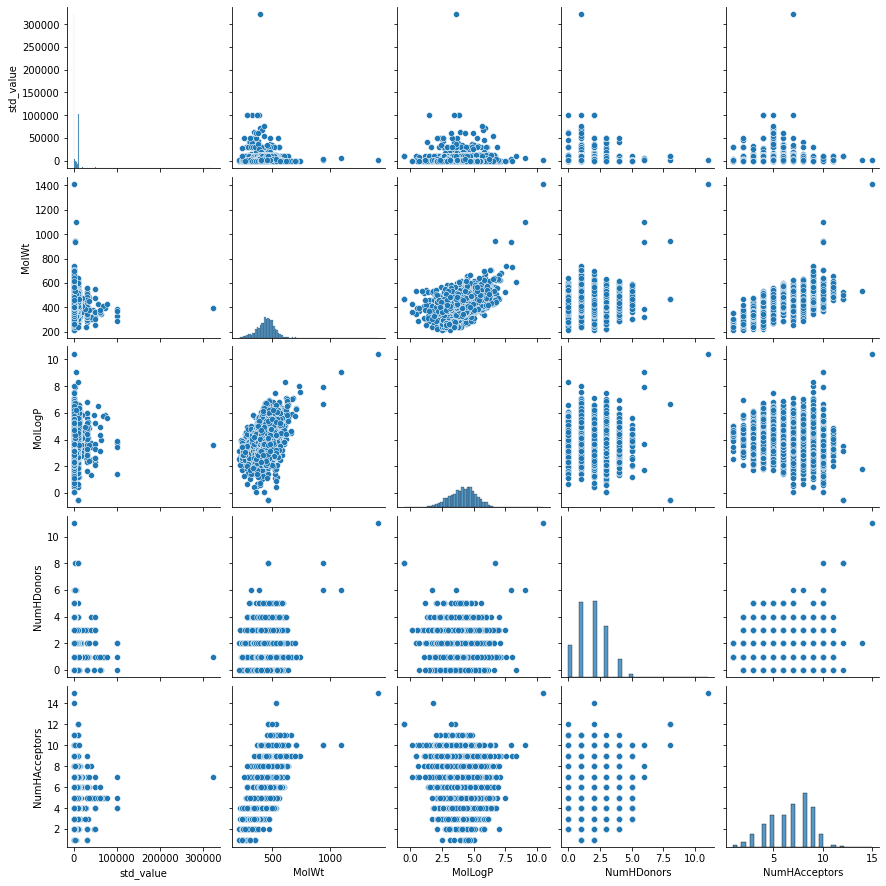

In [18]:
sns.pairplot(pair_df)

It looks like there is some sort of relationship between MolWt and MolLogP value; as one of these features increases, so does the other. Looking at the normal distributions, MolWt and MolLogP are normally distributed, NumHDonors is a little right skewed, NumHAcceptors is a little let skewed, and the range for the std_value distribution is extremely small. To make the std_value (which are IC50 values) distribution more normally distributed, I will put these values on a negative logarithmic scale. 

In [19]:
# From the Data Professor's notebook
def norm_value(input):
    norm = []

    for i in input['std_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['std_value_norm'] = norm
    x = input.drop('std_value', axis=1)
        
    return x

In [24]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []

    for i in input['std_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['log_std_value'] = pIC50
    x = input.drop('std_value_norm', 1)
        
    return x

In [25]:
df_norm = norm_value(cmbd_df)
df_norm

,mol_id,canon_smiles,Bioactivity,MolWt,MolLogP,NumHDonors,NumHAcceptors,std_value_norm
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,active,576.742,5.28050,1,8,128.0
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,active,562.715,5.03450,1,8,220.0
2,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,inactive,543.672,4.50748,1,8,8790.0
3,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,inactive,543.672,4.36498,1,8,1910.0
4,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,inactive,493.615,4.59032,2,7,30000.0
...,...,...,...,...,...,...,...,...
2839,CHEMBL1971943,Cc1c[nH]c2nccc(Oc3c(F)cc(Nc4cc(Cl)nc(N)n4)cc3F...,active,402.792,4.71102,3,6,303.0
2840,CHEMBL4088216,CN1C(=O)[C@@H](N2CCc3cn(Cc4ccccc4)nc3C2=O)COc2...,active,402.454,2.35370,0,5,1000.0
2841,CHEMBL4531334,CN1CCN(C(=O)C(C)(C)c2ccc(C(=O)Nc3cn4cc(-c5ccnc...,active,482.588,3.70020,1,6,668.0
2842,CHEMBL4549667,CN1C(=O)[C@@H](N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)...,active,481.350,3.11620,0,5,1000.0


In [26]:
df_norm['std_value_norm'].describe()

count      2844.000000
mean       4347.945036
std        9819.619398
min           0.101000
25%          28.000000
50%         450.000000
75%       10000.000000
max      322000.000000
Name: std_value_norm, dtype: float64

In [27]:
df_log = pIC50(df_norm)
df_log

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


,mol_id,canon_smiles,Bioactivity,MolWt,MolLogP,NumHDonors,NumHAcceptors,log_std_value
0,CHEMBL330863,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,active,576.742,5.28050,1,8,6.892790
1,CHEMBL124660,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,active,562.715,5.03450,1,8,6.657577
2,CHEMBL126699,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,inactive,543.672,4.50748,1,8,5.056011
3,CHEMBL445636,COc1cc2c(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)ncnc2cc...,inactive,543.672,4.36498,1,8,5.718967
4,CHEMBL941,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,inactive,493.615,4.59032,2,7,4.522879
...,...,...,...,...,...,...,...,...
2839,CHEMBL1971943,Cc1c[nH]c2nccc(Oc3c(F)cc(Nc4cc(Cl)nc(N)n4)cc3F...,active,402.792,4.71102,3,6,6.518557
2840,CHEMBL4088216,CN1C(=O)[C@@H](N2CCc3cn(Cc4ccccc4)nc3C2=O)COc2...,active,402.454,2.35370,0,5,6.000000
2841,CHEMBL4531334,CN1CCN(C(=O)C(C)(C)c2ccc(C(=O)Nc3cn4cc(-c5ccnc...,active,482.588,3.70020,1,6,6.175224
2842,CHEMBL4549667,CN1C(=O)[C@@H](N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)...,active,481.350,3.11620,0,5,6.000000


In [29]:
df_log['log_std_value'].describe()

count    2844.000000
mean        6.475101
std         1.362804
min         3.492144
25%         5.000000
50%         6.346787
75%         7.552842
max         9.995679
Name: log_std_value, dtype: float64

In [30]:
df_log.describe()

,MolWt,MolLogP,NumHDonors,NumHAcceptors,log_std_value
count,2844.000000,2844.000000,2844.000000,2844.000000,2844.000000
mean,446.127856,4.120522,1.864979,6.738045,6.475101
std,78.426022,1.112296,1.218360,2.082526,1.362804
min,210.236000,-0.538900,0.000000,1.000000,3.492144
25%,402.410000,3.394285,1.000000,5.000000,5.000000
50%,449.172500,4.189000,2.000000,7.000000,6.346787
75%,495.580750,4.863925,3.000000,8.000000,7.552842
max,1412.367000,10.443700,11.000000,15.000000,9.995679


In [32]:
for i, x in enumerate(df_log['MolLogP']):
  if x > 10:
    print(i, x)

798 10.443699999999996


In [36]:
def outliers(feature):

  score_limit = 3
  mean = np.mean(feature)
  std = np.std(feature)

  outliers = []
  for i, x in enumerate(feature):
    if (x - mean)/std > score_limit:
      outliers.append((i,x))
  return outliers

In [37]:
outliers(df_log['MolWt'])

[(798, 1412.367),
 (799, 942.2500000000001),
 (800, 1098.0259999999998),
 (801, 938.218),
 (853, 727.7149999999996),
 (955, 707.6809999999996),
 (1204, 740.2069999999995),
 (2183, 706.7499999999994),
 (2358, 706.7499999999994),
 (2672, 696.7519999999995)]

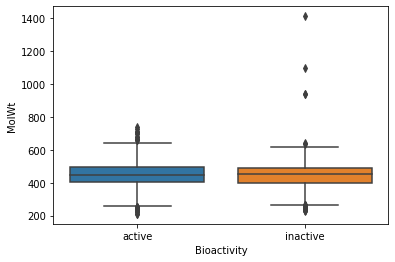

In [45]:
sns.boxplot(x='Bioactivity', y='MolWt', data = df_log)

In [49]:
outliers(df_log['MolLogP'])

[(798, 10.443699999999996),
 (800, 9.034),
 (801, 7.937200000000006),
 (853, 8.009700000000006),
 (1204, 7.54000000000001),
 (1498, 8.326900000000004)]

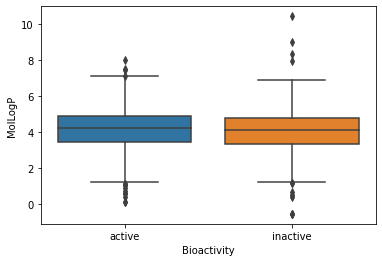

In [46]:
sns.boxplot(x='Bioactivity', y='MolLogP', data = df_log)

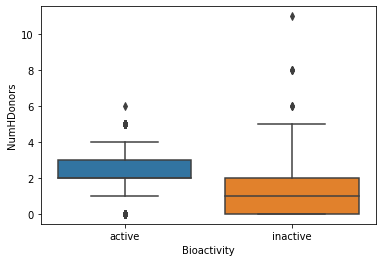

In [47]:
sns.boxplot(x='Bioactivity', y='NumHDonors', data = df_log)

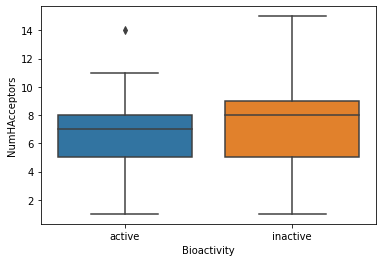

In [48]:
sns.boxplot(x='Bioactivity', y='NumHAcceptors', data = df_log)